# ROMY & RLAS

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory, read
from scipy.signal import welch

from functions.get_fband_average import __get_fband_average
from functions.get_median_psd import __get_median_psd

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
from andbro__read_sds import __read_sds

In [18]:
## ---------------------------------------

config = {}


config['station1'] = "BW.ROMY.10.BJZ"
config['station2'] = "BW.RLAS..BJZ"

config['tbeg'] = UTCDateTime("2023-09-23 01:00")

config['tend'] = UTCDateTime("2023-09-23 02:00")

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_figures'] = data_path+f"VelocityChanges/figures/"

config['path_to_inv'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

In [5]:
inv1 = read_inventory(config['path_to_inv']+"dataless.seed.BW_ROMY")
inv2 = read_inventory(config['path_to_inv']+"dataless.seed.BW_RLAS")

In [6]:
st1 = __read_sds(config['path_to_sds'], config['station1'], config['tbeg'], config['tend'])
# st2 = __read_sds(config['path_to_sds'], config['station2'], config['tbeg'], config['tend'])
st2 = read(root_path+"Downloads/mseed/RLAS_BJZ_2023-09-23.mseed")

In [7]:
st1.remove_sensitivity(inv1)
st2.remove_sensitivity(inv2)

1 Trace(s) in Stream:
BW.RLAS..BJZ | 2023-09-23T00:59:59.977250Z - 2023-09-23T01:59:59.977250Z | 20.0 Hz, 72001 samples

In [ ]:
st1.detrend("linear")
st2.detrend("linear")

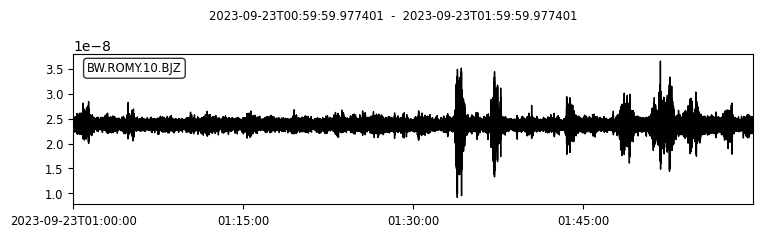

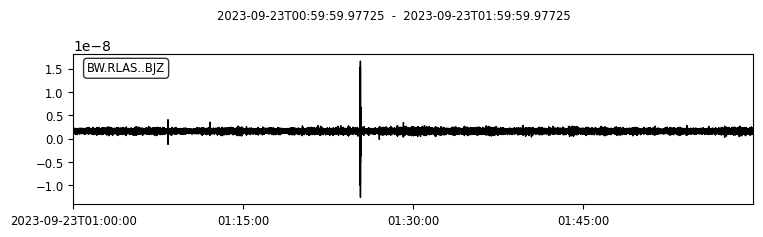

In [8]:
st1.plot();
st2.plot();

## Cross Wavelet Transform

In [13]:
def __compute_cross_wavelet_transform(times, arr1, arr2, tdelta, datalabels=["dat1", "dat2"], cmap_scale="log", xscale="lin", fmax_limit=None, normalize=False, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, ones, nan_to_num, percentile
    from numpy import sum as npsum

    import matplotlib.colors as colors
    import matplotlib.pyplot as plt

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask


    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## normalize, if desired
    # if normalize:
    #     arr1 /= nanmax(abs(arr1))
    #     arr2 /= nanmax(abs(arr2))

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)

    ## compute cross-wavelet transform
    xwt, cone_p, ff_xwt, d = xwt(
                                arr1,
                                arr2,
                                dt=dt,
                                dj=dj_set, #0.05,
                                s0=s0_set, #-1,
                                J=J_set, #-1,
                                significance_level=significance_threshold,
                                wavelet=mother_wavelet,  # u'morlet',
                                normalize=True,
                               )

    cone_f = 1/cone_p

    ## building cone
    mask_cone = __mask_cone(xwt, ff_xwt, cone_f, fill=nan)


    ## get real part
    xwt_power = abs(xwt)


    ## normalize cross wavelet transform
    # xwt_power /= nanmax(xwt_power.reshape((1, xwt_power.size))[0])

    ## apply masks
    xwt_power_masked = xwt_power * mask_cone

    ## compute global cross wavelet transform power
    global_mean_xwt_f = nanmean(xwt_power_masked, axis=1)

    global_sum_xwt_f = npsum(nan_to_num(xwt_power_masked, 0), axis=1)
    global_sum_xwt_f /= max(global_sum_xwt_f)


    xwt_min = percentile(xwt_power.reshape((1, xwt_power.size))[0], 90)
    xwt_max = percentile(xwt_power.reshape((1, xwt_power.size))[0], 10)

    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        N = 4

        fig, ax = plt.subplots(N, 1, figsize=(15, 7))

        caxs = []

        plt.subplots_adjust(hspace=0.3)

        ax[0].plot(times, arr1, alpha=1, color="black", lw=1, label=datalabels[0])
        ax[0].set_xlim(min(times), max(times))
        ax[0].set_ylabel(" Amplitude")
        ax[0].legend(loc=1)

        ax[1].plot(times, arr2, alpha=1, color="tab:red", lw=1, label=datalabels[1])
        ax[1].set_xlim(min(times), max(times))
        ax[1].set_ylabel("Amplitude")
        ax[1].legend(loc=1)

        if normalize:
            ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power_masked)
        else:
            if cmap_scale == "log":
                ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power,
                                       rasterized=True,
                                       norm=colors.LogNorm(vmin=xwt_min, vmax=xwt_max)
                                      )
            else:
                ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power,
                                       vmin=xwt_min,
                                       vmax=xwt_max,
                                       rasterized=True,
                                      )
        ## plot cone
        # ax[2].plot(times, cone_f, color="white")
        ax[2].fill_between(times, 0, cone_f, color="white", alpha=0.3)

        ax[2].set_ylabel("Frequency (Hz)")

        # ax[3].plot(ff_xwt, global_sum_xwt_f, color="red", label="global sum power (masked)")
        ax[3].plot(ff_xwt, global_mean_xwt_f, color="black", label="global mean power (masked)")

        ax[3].legend()
        ax[3].set_ylabel("global XWT")
        ax[3].set_xlabel("Frequency (Hz)")


        for n in range(N):
            caxs.append(make_axes_locatable(ax[n]).append_axes("right", size="2%", pad=0.05))
        cbar2 = plt.colorbar(ca2, cax=caxs[2], label="power", extend='both')
        caxs[0].remove()
        caxs[1].remove()
        caxs[3].remove()

        if normalize:
            ax[0].set_ylim(-1, 1)
            ax[1].set_ylim(-1, 1)

        if fmax_limit:
            if fmax_limit*2 <= 20:
                ax[3].set_xlim(0, fmax_limit*2)
                ax[2].set_ylim(0, fmax_limit*2)

        if xscale == "log":
            ax[3].set_xscale("log")
            ax[2].set_yscale("log")

        ax[2].set_ylim(min(ff_xwt), max(ff_xwt))

        plt.show();

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_xwt
    out['xwt_power'] = xwt_power
    out['cone_mask'] = mask_cone
    out['global_mean_xwt'] = global_mean_xwt_f
    out['global_sum_xwt'] = global_sum_xwt_f


    if plot:
        out['fig'] = fig

    return out

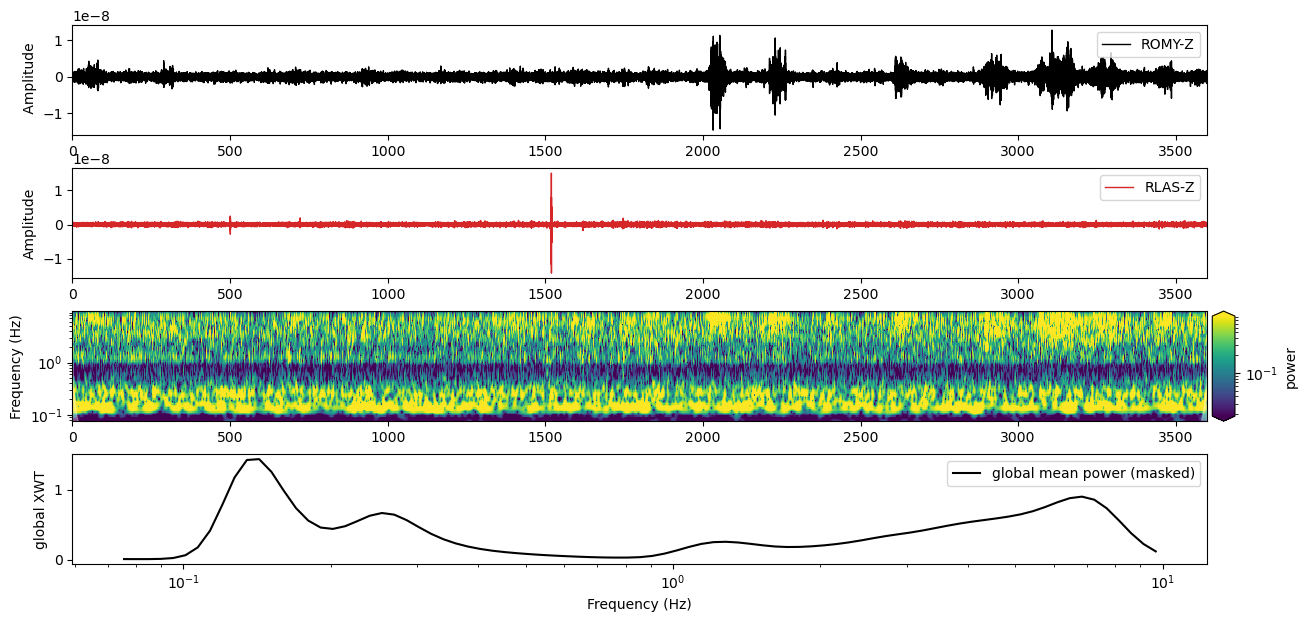

In [19]:
tt = st1[0].times()

dt = st1[0].stats.delta

dat1 = st1[0].data
dat2 = st2[0].data

out = __compute_cross_wavelet_transform(tt, dat1, dat2, dt,
                                        datalabels=["ROMY-Z", "RLAS-Z"],
                                        xscale="log",
                                        cmap_scale="log",
                                        plot=True)

out['fig'].savefig(config['path_to_figures']+f"Waveforms_RLAS_ROMY_XWT_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')
